# Jupyter Notebook to scrape Earning Transcript from seekingAlpha.com

In [72]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup as BS
import re
import os

### 0. Make directories 
Notice that the default path of the `Transcript` folder is in the same directory of this jupyter notebook

In [ ]:
# make dirs

sectors = ['basic-materials',
          'conglomerates',
          'consumer-goods',
          'financial',
          'healthcare',
          'industrial-goods',
          'services',
          'technology',
          'utilities']

if not os.path.exists('./Transcripts'):
    os.mkdir('Transcripts')
for sec in sectors:
    if not os.path.exists('Transcripts/{}'.format(sec)):
        os.mkdir('Transcripts/{}'.format(sec))

### 1. Login to Seeking Alpha

You probably need to manually go to the popped chrome page and **press to show you are not a robot**

In [3]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_experimental_option("useAutomationExtension", False)
chrome_options.add_experimental_option("excludeSwitches",["enable-automation"])
driver = webdriver.Chrome(ChromeDriverManager().install(),options=chrome_options,)

driver.get("https://seekingalpha.com/account/login")
email = driver.find_element_by_name("email")
email.send_keys("zhouxing@uchicago.edu")
password = driver.find_element_by_id("signInPasswordField")
password.send_keys("Xz19980114!")
driver.find_element_by_xpath("//button[@type='submit']").click()

[WDM] - Trying to download new driver from http://chromedriver.storage.googleapis.com/88.0.4324.96/chromedriver_mac64.zip
[WDM] - Unpack archive /Users/zhou/.wdm/drivers/chromedriver/88.0.4324.96/mac64/chromedriver.zip


### 2. Get all the urls of transcripts under the HealthCare sector

In [4]:
def find_time_name_from_title(text):
    time_lst = re.findall(r"Q[0-9] 2[0-9]{3}",text)
    name_lst = re.findall(r'\((.+?)\)',text)
    return time_lst,name_lst

In [5]:
def write_urls(num_page_range,sector):
    cnt = 0
    filepath = "Transcripts/{}/urls.txt".format(sector)
    if os.path.exists(filepath):
        os.remove(filepath)
    with open(filepath,"a+") as f:
        for page in num_page_range:
            driver.get("https://seekingalpha.com/earnings/earnings-call-transcripts/{}?sector={}".format(page,sector))
            content = driver.find_elements_by_xpath("//a[@sasource='earnings-center-transcripts_article']")
            for i in range(len(content)):
                title = content[i].text
                time_lst,name_lst = find_time_name_from_title(title)
                if len(time_lst)!=1 or len(name_lst)!=1:
                    continue
                Time = time_lst[0].replace(" ","")
                Name = name_lst[0]
                url = content[i].get_attribute('href')
                f.write("{};{};{}\n".format(Name,Time,url))
                cnt+=1
    f.close()
    print("urls:",cnt)                      

Run the following block, and in the prompt, type a sector among `['healthcare', 'financial', 'consumer-goods', 'conglomerates', 'services', 'technology', 'utilities', 'industrial-goods']`.

In [6]:
# sector and how many pages to scrape the urls
# The values are number of pages to cover 2021 - 2020. You may need to increase it if you would like to get older transcripts.
sec_pages = {"healthcare":42,
            "financial":52,
            "consumer-goods":24,
             "conglomerates":2,
             "services":48,
             "technology":66,
             "utilities":8,
             'industrial-goods':26
            }
sector = input("sector:")
write_urls(range(sec_pages[sector]),sector)

sector: utilities


urls: 234


In [73]:
def write_transcipt(name,time,url,sector):
    
    dirpath = "Transcripts/{}/Transcripts".format(sector)
    if not os.path.exists(dirpath):
        os.mkdir(dirpath)
        
    filepath = "Transcripts/{}/Transcripts/{}_{}.txt".format(sector,name,time)
    
    if os.path.exists(filepath):
        return 
    
    # To get the rendered DOM html, instead of the HTML
    driver.get(url)
    WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.XPATH, "//div[@data-test-id='content-container']")))
    content = driver.page_source
    
    soup = BS(content)
    result = BS(str(soup.findAll("div", {"data-test-id" : "content-container"})[0]))
    text = [i.text for i in result.findAll('p')]

    with open(filepath,"a+") as f:
        for line in text:
            f.write("{}\n".format(line))
    f.close()
    return "\n".join(text)

When running the following block, you probably need to manually go to the popped chrome page and **press to show you are not a robot**

finished: 0
error: 1
<html lang="en" prefix="og:http://ogp.me/ns#" style="--headerHeight:90px; --scrollbar-width:15px;"><head>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
<script type="text/javascript" async="" src="https://sb.scorecardresearch.com/c2/33317597/cs.js"></script><script type="text/javascript" src="https://cdn.krxd.net/userdata/get?pub=88a388a7-f531-4ebc-929a-e93320909d66&amp;callback=Krux.ns.seekingalpha.kxjsonp_userdata"></script><script type="text/javascript" src="https://beacon.krxd.net/optout_check?callback=Krux.ns.seekingalpha.kxjsonp_optOutCheck"></script><script src="https://www.googletagservices.com/activeview/js/current/osd.js?cb=%2Fr20100101"></script><script type="text/javascript" async="" src="https://www.google-analytics.com/analytics.js"></script><script type="text/javascript" async="" src="https://www.google-analytics.com/analytics.js"></script><script type="text/javascript" async="" src="https://www.google-analytics.com/gtm/js?id=OP
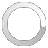
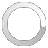
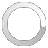
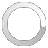
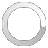
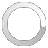
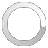
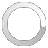
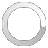
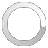
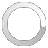
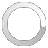
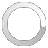
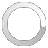
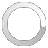
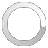
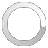
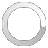

In [75]:
filepath = "Transcripts/{}/urls.txt".format(sector)
with open(filepath,'rb') as f:
    res = f.read().decode('ascii').split('\n')
    for idx,i in enumerate(res[:20]):
        name,time,url = i.split(';')
        try:
            text = write_transcipt(name,time,url,sector)
        except:
            print("error:",idx)

In [17]:
df.head()

Empty DataFrame
Columns: [name, time, url, transcript]
Index: []

In [42]:
from bs4 import BeautifulSoup